In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [2]:
%matplotlib tk

arm_mass = 0.2 #kg
arm_length = 0.6 #meter
motor_mass = 0.065

arm_lengths = [arm_length,]*4

total_inertia_tensor = np.zeros((3, 3))

arms_inertia_tensor = np.zeros((3, 3))
arms_inertia_tensor[0, 0] = 2*(1/12)*arm_mass*arm_length**2
arms_inertia_tensor[1, 1] = (1/12)*arm_mass*arm_length**2
arms_inertia_tensor[2, 2] = (1/12)*arm_mass*arm_length**2

motors_inertia_tensor = np.zeros((3, 3))
motors_inertia_tensor[0, 0] = 2*motor_mass*arm_length**2
motors_inertia_tensor[1, 1] = 2*motor_mass*arm_length**2
motors_inertia_tensor[2, 2] = 4*motor_mass*arm_length**2

total_inertia_tensor = arms_inertia_tensor + motors_inertia_tensor

In [3]:
def get_dyn_constants(body_mass):
    prop_radius = 0.1016 # meters
    prop_pitch = 0.1143 # meters
    c_d = 0.09 # airfoil
    body_max_omega_z = 3600*(np.pi/180) # radians/second; max body angular velocity about z axis
    
    neutral_buoyancy_pulse = 750 # unitless
    g = 9.81
    k_force = body_mass*g/(4*((neutral_buoyancy_pulse)**2))
    k_torque = 0.5*(prop_radius**4)*prop_pitch*c_d*(body_max_omega_z**2)/(10**2)
    return k_force, k_torque


In [4]:
def get_body_constants():
    
    arm_mass = 0.2 #kg
    arm_length = 0.6 #meter
    motor_mass = 0.065

    arm_lengths = [arm_length,]*4

    total_inertia_tensor = np.zeros((3, 3))

    arms_inertia_tensor = np.zeros((3, 3))
    arms_inertia_tensor[0, 0] = (1/12)*arm_mass*arm_length**2
    arms_inertia_tensor[1, 1] = (1/12)*arm_mass*arm_length**2
    arms_inertia_tensor[2, 2] = (1/12)*arm_mass*arm_length**2

    motors_inertia_tensor = np.zeros((3, 3))
    motors_inertia_tensor[0, 0] = 2*motor_mass*arm_length**2
    motors_inertia_tensor[1, 1] = 2*motor_mass*arm_length**2
    motors_inertia_tensor[2, 2] = 4*motor_mass*arm_length**2

    total_inertia_tensor = arms_inertia_tensor + motors_inertia_tensor

    body_mass = arm_mass*2 + motor_mass*4
    return body_mass, total_inertia_tensor, arm_lengths

In [5]:
def DCM_from_quat(q):
    R = np.zeros((3, 3))
    R[0, 0] = 1. - 2.*(q[2]**2 + q[3]**2)
    R[0, 1] = 2.*(q[1]*q[2] - q[0]*q[3])
    R[0, 2] = 2.*(q[0]*q[2] + q[1]*q[3])
    R[1, 0] = 2.*(q[1]*q[2] + q[0]*q[3])
    R[1, 1] = 1. - 2.*(q[1]**2 + q[3]**2)
    R[1, 2] = 2.*(q[3]*q[2] - q[1]*q[0])
    R[2, 0] = 2.*(q[1]*q[3] - q[0]*q[2])
    R[2, 1] = 2.*(q[1]*q[0] + q[3]*q[2])
    R[2, 2] = 1. - 2.*(q[1]**2 + q[2]**2)
    return R

In [6]:
def tait_bryan_from_quat(q_cur):
    phi   = np.arctan2(2*(q_cur[0]*q_cur[1] + q_cur[2]*q_cur[3]), 1. - 2.*(q_cur[1]**2 + q_cur[2]**2))*180/np.pi
    theta = np.arcsin(2*(q_cur[0]*q_cur[2] - q_cur[3]*q_cur[1]))*180/np.pi
    psi   = np.arctan2(2*(q_cur[0]*q_cur[3] + q_cur[1]*q_cur[2]), 1. - 2.*(q_cur[2]**2 + q_cur[3]**2))*180/np.pi
    return phi, theta, psi #returns degrees

In [7]:
def quat_mult(q1, q2):
    #print(q1, q2)
    #print(q1.shape, q2.shape)
    #q3 = np.zeros((1, 4))
    q3 = np.array([0., 0., 0., 0.,])
    q3[0] = q1[0]*q2[0] - q1[1:].dot(q2[1:])
    q3[1:] = q1[0]*q2[1:] + q2[0]*q1[1:] + np.cross(q1[1:], q2[1:])
    return q3

In [8]:
def quat_inv(q1):
    #q2 = np.zeros((1, 4))
    q2 = np.array([0., 0., 0., 0.,])
    mag = np.linalg.norm(q1)
    q2[0] = q1[0]
    q2[1:] = -1.*q1[1:]
    q2 /= (mag*mag)
    return q2

In [9]:
def calc_omega_dot_body(omega_body, inertia_body, torques_body):
    cp = np.cross(omega_body, inertia_body.dot(omega_body))
    inv_inert = np.linalg.inv(inertia_body)
    #print("inv inertia:\n", inv_inert)
    #print("omega_dot_body cross product:", cp)
    omega_dot_body = inv_inert.dot(torques_body - cp)
    return omega_dot_body

In [10]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_torques_body(motor_speeds, arm_lengths, k_force, k_torque):
    #torques_body = np.zeros((1, 3))
    torques_body = np.array([0., 0., 0.,])
    #print("torques_body:", torques_body)
    torques_body[0] = arm_lengths[1]*k_force*(motor_speeds[1]**2) - arm_lengths[3]*k_force*(motor_speeds[3]**2)
    torques_body[1] = arm_lengths[2]*k_force*(motor_speeds[2]**2) - arm_lengths[0]*k_force*(motor_speeds[0]**2)
    #torques_body[0] = arm_lengths[3]*k_force*(motor_speeds[3]**2) + arm_lengths[2]*k_force*(motor_speeds[2]**2) - arm_lengths[0]*k_force*(motor_speeds[0]**2) - arm_lengths[1]*k_force*(motor_speeds[1]**2)
    #torques_body[1] = arm_lengths[3]*k_force*(motor_speeds[3]**2) - arm_lengths[2]*k_force*(motor_speeds[2]**2) + arm_lengths[0]*k_force*(motor_speeds[0]**2) - arm_lengths[1]*k_force*(motor_speeds[1]**2)
    torques_body[2] = k_torque*(-1*motor_speeds[0]**2 + motor_speeds[1]**2 - motor_speeds[2]**2 + motor_speeds[3]**2)
    #print("torques_body after stuff:", torques_body)
    return torques_body

In [11]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_forces_body(motor_speeds, k_force):
    #forces_body = np.zeros((1, 3))
    forces_body = np.array([0., 0., 0.,])
    forces_body[2] = k_force*sum([s**2 for s in motor_speeds])
    return forces_body

In [12]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def update_orientation_body(
    omega_body_prev,
    q_body_prev,
    dt,
    arm_lengths,
    k_force,
    k_torque,
    inertia_body,
    motor_speeds
):
    torques_body = get_torques_body(motor_speeds, arm_lengths, k_force, k_torque)
    #print("torques:", torques_body)
    omega_dot_body = calc_omega_dot_body(omega_body_prev, inertia_body, torques_body)
    #print("omega_dot_body", omega_dot_body)
    omega_body = omega_body_prev + omega_dot_body*dt
    #print("omega_body_prev:", omega_body_prev)
    
    theta = -np.pi/2 - np.pi/4
    R_z = np.zeros((3, 3))
    R_z[0, 0] = np.cos(theta)
    R_z[0, 1] = -np.sin(theta)
    R_z[1, 0] = np.sin(theta)
    R_z[1, 1] = np.cos(theta)
    R_z[2, 2] = 1.
    omega_body_rot = R_z.dot(omega_body)
    #print("omega_body_rot:", omega_body_rot)
    delta_theta_dot = np.linalg.norm(omega_body_rot)
    quat_omega_body = np.array([np.cos(delta_theta_dot*dt/2.)] + list(np.sin(delta_theta_dot*dt/2.)*omega_body_rot/(delta_theta_dot + 1e-8)))
    q_body = quat_mult(q_body_prev, quat_omega_body)
    if np.linalg.norm(q_body) < 0.999:
        q_body += 0.1*(1. - np.linalg.norm(q_body)**2)*q_body
    #print("q_body update_orientation_body:", q_body)
    return q_body, omega_body

In [13]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def get_force_inertial(vel_inert_prev, q_body, motor_speeds, k_force, k_damp, body_mass):

    forces_body = get_forces_body(motor_speeds, k_force)
    #print("forces_body:", forces_body)
    forces_body_quat = np.array([0., 0., 0., 0.,])
    forces_body_quat[1:] = forces_body
    net_force_inert = body_mass*np.array([0, 0, -9.8]) + \
        quat_mult(quat_mult(quat_inv(q_body), forces_body_quat), q_body)[1:] - \
        k_damp*vel_inert_prev
    #net_force_inert = body_mass*np.array([0, 0, -9.8]) + \
    #    quat_mult(quat_mult(q_body, forces_body_quat), quat_inv(q_body))[1:] - \
    #    k_damp*vel_inert_prev
    return net_force_inert

In [14]:
# Expects motor_speeds to be a 4-length array with values of (pulse_width_i - 1000)
def update_pos_vel_inertial(
    pos_inert_prev,
    vel_inert_prev,
    accel_inert_prev,
    q_body,
    motor_speeds,
    k_force,
    k_damp,
    body_mass,
    dt
):
    
    # Velocity verlet
    pos_inert = pos_inert_prev + vel_inert_prev*dt + 0.5*accel_inert_prev*dt*dt
    accel_inert = get_force_inertial(vel_inert_prev, q_body, motor_speeds, k_force, k_damp, body_mass)/body_mass
    #print("accel_inert:", accel_inert)
    vel_inert = vel_inert_prev + 0.5*(accel_inert + accel_inert_prev)*dt
    
    return pos_inert, vel_inert, accel_inert

In [15]:
class PID(object):
    def __init__(self, kp, ki, kd, out_max=np.inf, out_min=-np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.out_max = out_max
        self.out_min = out_min
        self.error_prev = 0.
        self.error_integ = 0.
        self.updated = False
        
    def update(self, sig_in, sig_set):
        #error = sig_in - sig_set
        error = sig_set - sig_in
        if not self.updated:
            sig_out = self.kp*error
            self.error_prev = error
            self.error_integ += error
            self.updated = True
            return sig_out
        
        error_dot = error - self.error_prev
        self.integrate(error)
        sig_out = self.kp*error + self.kd*error_dot + self.ki*self.error_integ
        sig_out_bounded = self.bound(sig_out)
        self.error_prev = error
        #print("sig out bounded:", sig_out_bounded, "sig out:", sig_out)
        return sig_out_bounded
        
    def bound(self, sig_out):
        #print("sig_out < out_max:", sig_out < self.out_max)
        #print("sig_out > out_min:", sig_out > self.out_min)
        #print("min, sig_out, max:", self.out_min, self.out_max, sig_out)
        return max(
            min(sig_out, self.out_max),
            self.out_min
        )
    
    def integrate(self, error):
        if self.error_integ <= self.out_max and self.error_integ >= self.out_min:
            self.error_integ += error
            
        return self.error_integ

class AttitudeController(object):
    # Cascaded PID controller
    # theta_cur ___     _____
    #              |___|     |
    #               ___| PID |____
    # theta_set ___|   |_____|    |                    _____
    #                             |__theta_dot_set____|     |
    #                                             ____| PID |___motor_pulse___
    # theta_dot_cur______________________________|    |_____|
    
    def __init__(self, angle_gains, omega_gains, omega_bounds, psi_gains, psi_bounds):
        self.pid_phi        = PID(angle_gains[0], angle_gains[1], angle_gains[2])
        self.pid_theta      = PID(angle_gains[0], angle_gains[1], angle_gains[2])
        self.pid_phi_dot    = PID(omega_gains[0], omega_gains[1], omega_gains[2], max(omega_bounds), min(omega_bounds))
        self.pid_theta_dot  = PID(omega_gains[0], omega_gains[1], omega_gains[2], max(omega_bounds), min(omega_bounds))
        self.pid_psi_dot    = PID(psi_gains[0], psi_gains[1], psi_gains[2], max(psi_bounds), min(psi_bounds))
    
    def update(self, q_cur, omega_cur, setpoints):
        # omega_cur = [rad/s, rad/s, rad/s]
        # angle_setpoints = [deg_roll, deg_pitch, deg_yaw/s]

        phi   = np.arctan2(2*(q_cur[0]*q_cur[1] + q_cur[2]*q_cur[3]), 1. - 2.*(q_cur[1]**2 + q_cur[2]**2))*180/np.pi
        theta = np.arcsin(2*(q_cur[0]*q_cur[2] - q_cur[3]*q_cur[1]))*180/np.pi

        #print("controller update phi:", phi, "\t theta:", theta, "\t q_cur magnitude:", np.linalg.norm(q_cur))
        
        phi_dot   = omega_cur[0]*180/np.pi
        theta_dot = omega_cur[1]*180/np.pi
        psi_dot   = omega_cur[2]*180/np.pi
        
        omega_setpoint = [None, None, None]
        omega_setpoint[0] = self.pid_phi.update(phi, setpoints[0])
        omega_setpoint[1] = self.pid_theta.update(theta, setpoints[1])
        omega_setpoint[2] = self.pid_psi_dot.update(psi_dot, setpoints[2])
        
        #print("roll_dot_setpoint:", omega_setpoint[0])
        
        roll_command  = self.pid_phi_dot.update(phi_dot, omega_setpoint[0])
        pitch_command = self.pid_theta_dot.update(theta_dot, omega_setpoint[1])
        yaw_dot_command = omega_setpoint[2]
        
        return roll_command, pitch_command, yaw_dot_command
    
    # Callable function returns motor pulses
    def __call__(self, q_cur, omega_cur, setpoints, throttle):
        roll_comm, pitch_comm, yaw_dot_comm = self.update(q_cur, omega_cur, setpoints)
        #print("roll command:", roll_comm, "\t pitch command:", pitch_comm, "\t yaw dot command:", yaw_dot_comm)
        # which motors are on the left and which are on the right? goddamnit.
        # Right side: M1, M2
        # Left side: M3, M4
        '''
                   Front
            CW   M3     M2  CCW
                   \   /
                    \_/
            Left    |_|   Right
                    / \
                   /   \
            CCW  M4     M1  CW
                   Back
        '''
        
        motor_pulses = [0,]*4
        motor_pulses[0] = throttle + roll_comm - pitch_comm - yaw_dot_comm
        motor_pulses[1] = throttle + roll_comm + pitch_comm + yaw_dot_comm
        motor_pulses[2] = throttle - roll_comm + pitch_comm - yaw_dot_comm
        motor_pulses[3] = throttle - roll_comm - pitch_comm + yaw_dot_comm
        return motor_pulses

In [16]:
def run_6dof(
    num_timesteps, # number of dt's
    dt,
    pos_init,
    vel_init,
    q_init,
    omega_init,
    controller=(lambda *x: np.array([750,]*4))
):
    body_mass, body_inertia_tensor, arm_lengths = get_body_constants()
    print("body inertia tensor:\n\n", body_inertia_tensor)
    k_force, k_torque = get_dyn_constants(body_mass)
    print("k_force:", k_force)
    print("k_torque:", k_torque)
    print("body_mass:", body_mass)
    print("4*k_force*ms**2:", 4*k_force*(750**2))
    k_damp = 0.5 #swag
    omega_prev = omega_init
    pos_prev = pos_init
    vel_prev = vel_init
    accel_prev = np.array([0., 0., 0.])/body_mass
    q_prev = q_init
    
    first_run = True
    
    pos_cur = None
    vel_cur = None
    accel_cur = None
    q_cur = None
    omega_cur = None
    
    positions = []
    qs = []
    motor_speeds = [750,]*4
    times = []
    
    for step in range(0, num_timesteps):
        command_angles = []
        command_throttle = 0
        if step >= 0 and step*dt <= 1.5:
            command_angles = [45, 0, 0]
            command_throttle = 900
        elif step*dt > 1.5 and step*dt <= 3.0:
            command_angles = [-45, 0., 0]
            command_throttle = 900
        elif step*dt > 3.0 and step*dt <= 3.3:
            command_angles = [45, 0, 0]
            command_throttle = 900
        else:
            command_angles = [0., 0., 0]
            command_throttle = 750
        #command_angles = [0., 0., 0]
        #command_throttle = 750
        #print("###############################################")
        if first_run:
            motor_speeds = [750,]*4
            first_run = False
        else:
            motor_speeds = controller(q_prev, omega_prev, command_angles, command_throttle)
        #print("motor speeds:", motor_speeds)
        q_cur, omega_cur = update_orientation_body(
            omega_prev,
            q_prev,
            dt,
            arm_lengths,
            k_force,
            k_torque,
            body_inertia_tensor,
            motor_speeds
        )
        
        pos_cur, vel_cur, accel_cur = update_pos_vel_inertial(
            pos_prev,
            vel_prev,
            accel_prev,
            q_cur,
            motor_speeds,
            k_force,
            k_damp,
            body_mass,
            dt
        )
        pos_prev = pos_cur
        vel_prev = vel_cur
        accel_prev = accel_cur
        q_prev = q_cur
        omega_prev = omega_cur
        positions.append(pos_prev)
        qs.append(q_prev)
        
        if len(times) == 0:
            times.append(0.)
        else:
            times.append(times[-1] + dt)
        
        if np.any(np.isnan(q_cur)):
            print("Found nan in orientation quaternion, exiting")
            break
        
        if pos_cur[2] <= 0.:
            print("CM ended up below the floor, exiting")
            break
        
    return positions, qs, times

In [17]:
#n = np.array([0., 1., 1.])
n = np.array([1., 0., 0.])
n_hat = n/np.linalg.norm(n)
dtheta = 0*np.pi/2

q_init = np.array(
    [
        np.cos(dtheta/2),
        np.sin(dtheta/2)*n_hat[0],
        np.sin(dtheta/2)*n_hat[1],
        np.sin(dtheta/2)*n_hat[2],
    ]
)
#omega_init = 0.*np.array([np.pi/2, -np.pi, 2*np.pi])
omega_init = np.array([0., 0., 0.])
pos_init = np.array([0, 0, 10])
vel_init = 0*np.array([10, 10, 0])
g = 9.8 # meters/(second*second)

# Something weird is going on with the controller class, q_0 is wobbling
# around everywhere.
controller = AttitudeController([-10.0, 0.0, 10.], [2.0, 0.01, 10.], [-400, 400], [2.0, 0., 0.], [-400, 400])

positions, qs, times = run_6dof(10000, 0.0005, pos_init, vel_init, q_init, omega_init, controller)
print(10000*0.0005)

body inertia tensor:

 [[0.0528 0.     0.    ]
 [0.     0.0528 0.    ]
 [0.     0.     0.0996]]
k_force: 2.8776e-06
k_torque: 2.1636814048817637e-05
body_mass: 0.66
4*k_force*ms**2: 6.474600000000001
5.0


plt.figure()
plt.plot([p[0] for p in positions], [p[1] for p in positions])
plt.show()
#plt.figure()
#plt.plot([p[1] for p in positions])
#plt.show()
plt.figure()
plt.plot(times, [p[2] for p in positions])
plt.show()

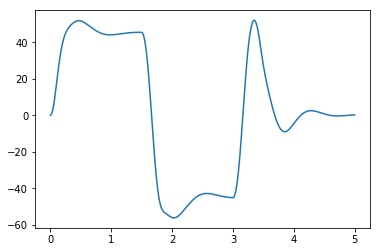

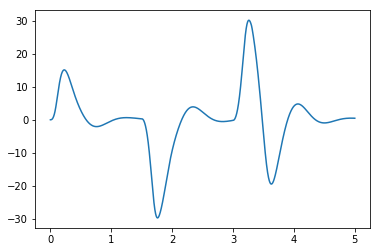

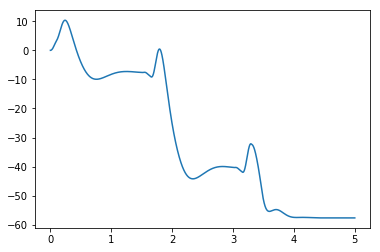

In [18]:
%matplotlib inline
phis = []
thetas = []
psis = []
for q_cur in qs:
    phi, theta, psi = tait_bryan_from_quat(q_cur)
    phis.append(phi)
    thetas.append(theta)
    psis.append(psi)
    
plt.figure()
plt.plot(times, phis)
plt.show()

plt.figure()
plt.plot(times, thetas)
plt.show()

plt.figure()
plt.plot(times, psis)
plt.show()

In [19]:
%matplotlib tk
print(5 % (len(qs)//100), 2 % 4)
qs = np.array(qs)
positions = np.array(positions)
print(positions.shape)
orientation_indices = np.array([i for i in range(len(qs)) if ((i % (len(qs)//100)) == 0) or (i == len(qs) - 1)]).astype(np.int32)
#print(orientation_indices, type(orientation_indices))
orientation_slices = qs[orientation_indices]
position_slices = positions[orientation_indices]
window_min = np.min(position_slices)
window_max = np.max(position_slices)

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_aspect('equal')
#ax.axis('equal')
ax.set_xlim3d(window_min, window_max)
ax.set_ylim3d(window_min, window_max)
ax.set_zlim3d(window_min, window_max)
corners_init = 1.5*np.array([[-0.2, -0.2, 0], [0.2, -0.2, 0], [0.2, 0.2, 0], [-0.2, 0.2, 0]])

corners = []
for q, r in zip(orientation_slices, position_slices):
    #print(r.shape)
    corners.append((DCM_from_quat(q).T.dot(corners_init.T)).T + r)

corners = np.array(corners)
#print(corners[:, 0, 0])
ax.scatter(corners[:, 0, 0], corners[:, 0, 1], corners[:, 0, 2])
ax.scatter(corners[:, 1, 0], corners[:, 1, 1], corners[:, 1, 2])
ax.scatter(corners[:, 2, 0], corners[:, 2, 1], corners[:, 2, 2])
ax.scatter(corners[:, 3, 0], corners[:, 3, 1], corners[:, 3, 2])
#ax.axis('equal')
#Axes3D.scatter(list(corners[:, 0, 0]), list(corners[:, 0, 1]), list(corners[:, 0, 2]))


5 2
(10000, 3)


In [20]:
def update_plot(num, data, line):
    print("num:", num)
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

In [21]:
#fig = plt.figure()
#ax = p3.Axes3D(fig)

positions = np.array(positions)
positions = positions.T
line, = ax.plot(positions[0, 0:1], positions[1, 0:1], positions[2, 0:1])
N = positions.shape[1]
#ani = animation.FuncAnimation(fig, update_plot, N, fargs=(positions, line), interval=10000/N, blit=False)
#ani.save('matplot003.gif', writer='imagemagick')
#plt.show()
#plt.close()

In [22]:
positions.shape

(3, 10000)

In [23]:
def wtf(d):
    x_prev = np.array([0., 0., 0.,])
    v_prev = np.array([0., 0., 0.,])
    a_prev = np.array([0., 0., 0.,])

    poss = []
    
    dt = 0.0001
    for t in range(0, 50000):
        x_next = x_prev + v_prev*dt + 0.5*a_prev*dt*dt
        a_next = np.array([0., 0., -9.8]) - d*v_prev
        v_next = v_prev + 0.5*(a_next + a_prev)*dt
        
        x_prev = x_next
        a_prev = a_next
        v_prev = v_next
        
        poss.append(x_prev)
        
    plt.figure()
    plt.plot([p[2] for p in poss])
    plt.show()

In [24]:
tait_bryan_from_quat(q_init)

(0.0, 0.0, 0.0)

In [25]:
body_mass, body_inertia_tensor, arm_lengths = get_body_constants()
print(np.linalg.inv(body_inertia_tensor))
print(body_inertia_tensor)

[[18.93939394  0.          0.        ]
 [ 0.         18.93939394  0.        ]
 [ 0.          0.         10.04016064]]
[[0.0528 0.     0.    ]
 [0.     0.0528 0.    ]
 [0.     0.     0.0996]]


In [26]:
#distances = []
#for k in range(len(corners)):
#    for i in range(4):
#        for j in range(4):
#            distances.append(np.linalg.norm(corners[k, i, :] - corners[k, j, :]))

In [27]:
#plt.plot(list(set(distances)))